# Part 2: Predicting Carbon Emissioin

###  In this section, we investigate the provided data, and make prediction on the carbon emission of the language models.

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor

### We first pick the quantitative features that contribute to carbon emission of each model, handled missing values in the "large_scale_ai_models_added_cols.csv" file, and then used models to predict.

In [2]:
df0 = pd.read_csv("large_scale_ai_models_added_cols.csv")

In [3]:
columns = ["System", "Domain", "Task", "Organization", "Parameters", "Training compute (FLOP)",
           "Training dataset size (datapoints)", "Hardware quantity", "Training power (Watts) ",
           "Training energy (kWh) ", "Carbon Emissions from training (lb)"]

In [4]:
df1 = df0[columns]
df1["Training power (Watts) "] = df1["Training power (Watts) "].astype(float)
df1["Training energy (kWh) "] = df1["Training energy (kWh) "].astype(float)
df1["Carbon Emissions from training (lb)"] = df1["Carbon Emissions from training (lb)"].astype(float)

/var/folders/bn/djfw0dcs753g25mz08w091680000gn/T/ipykernel_38136/208735848.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["Training power (Watts) "] = df1["Training power (Watts) "].astype(float)
/var/folders/bn/djfw0dcs753g25mz08w091680000gn/T/ipykernel_38136/208735848.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["Training energy (kWh) "] = df1["Training energy (kWh) "].astype(float)
/var/folders/bn/djfw0dcs753g25mz08w091680000gn/T/ipykernel_38136/208735848.py:4: SettingWithCopyWarning:

### Some models take on various tasks. We pivot the column to each name of the task to better assess each model, and gather more data points.

In [5]:
df1['Task'] = df1['Task'].str.replace('\n', '').str.strip()
df_exploded = df1.assign(Task=df1['Task'].str.split(',')).explode('Task')

df_exploded['Task'] = df_exploded['Task'].str.strip()

/var/folders/bn/djfw0dcs753g25mz08w091680000gn/T/ipykernel_38136/223903819.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Task'] = df1['Task'].str.replace('\n', '').str.strip()


In [7]:
df_exploded.groupby("Task")["Carbon Emissions from training (lb)"].count().sort_values(ascending=False)

Task
Language modelling/generation                     15
Language modelling                                10
Chat                                               6
Translation                                        5
Question answering                                 4
Code generation                                    4
Visual question answering                          3
Text-to-image                                      3
Vision-language generation                         2
Go                                                 2
Text autocompletion                                2
Audio generation                                   1
Image generation                                   1
Language generation                                1
Semantic search                                    1
Text summarization                                 1
Video generation                                   1
Text classification                                0
Table tasks                              

### Notice there are many missing values of the quantitative variables, we impute the missing places with the mean of available values.

In [8]:
df_exploded["Parameters"].fillna(df_exploded["Parameters"].mean(), inplace=True)
df_exploded["Training compute (FLOP)"].fillna(df_exploded["Training compute (FLOP)"].mean(), inplace=True)
df_exploded["Training dataset size (datapoints)"].fillna(df_exploded["Training dataset size (datapoints)"].mean(), inplace=True)
df_exploded["Hardware quantity"].fillna(df_exploded["Hardware quantity"].mean(), inplace=True)
df_exploded["Training power (Watts) "].fillna(0, inplace=True)
pd.set_option('display.float_format', '{:.6f}'.format)

/var/folders/bn/djfw0dcs753g25mz08w091680000gn/T/ipykernel_38136/2570745567.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_exploded["Parameters"].fillna(df_exploded["Parameters"].mean(), inplace=True)
/var/folders/bn/djfw0dcs753g25mz08w091680000gn/T/ipykernel_38136/2570745567.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on 

In [9]:
df3 = df_exploded[df_exploded["Carbon Emissions from training (lb)"].notnull()].reset_index(drop=True)

In [10]:
df3.shape

(62, 11)

In [11]:
df3

,System,Domain,Task,Organization,Parameters,Training compute (FLOP),Training dataset size (datapoints),Hardware quantity,Training power (Watts),Training energy (kWh),Carbon Emissions from training (lb)
0,Meta Movie Gen Video,Video,Video generation,Meta AI,30000000000.000000,1649999999999999945474048.000000,26600000000.000000,6144.000000,28000000000000.000000,9268000000000.000000,7970480000000.000000
1,Meta Movie Gen Audio,Audio,Audio generation,Meta AI,13000000000.000000,140000000000000008388608.000000,3415525467032.966797,384.000000,34700000000000.000000,12480500000000.000000,10733200000000.000000
2,Nemotron-4 340B,Language,Language modelling/generation,NVIDIA,340000000000.000000,17999999999999998624268288.000000,6750000000000.000000,5161.791304,36400000000000.000000,80018400000000.000000,68815800000000.000000
3,Nemotron-4 340B,Language,Chat,NVIDIA,340000000000.000000,17999999999999998624268288.000000,6750000000000.000000,5161.791304,36400000000000.000000,80018400000000.000000,68815800000000.000000
4,Chameleon-34B,"Multimodal,Image generation,Language,Vision",Language modelling/generation,Facebook AI Research,34000000000.000000,1649999999999999945474048.000000,4400000000000.000000,3072.000000,66800000000000.000000,93118400000000.000000,80081800000000.000000
...,...,...,...,...,...,...,...,...,...,...,...
57,GPT-3 175B (davinci),Language,Text autocompletion,OpenAI,175000000000.000000,313999999999999995805696.000000,374000000000.000000,10000.000000,22400000000000.000000,7956480000000.000000,6842570000000.000000
58,GPT-3 175B (davinci),Language,Language modelling/generation,OpenAI,175000000000.000000,313999999999999995805696.000000,374000000000.000000,10000.000000,22400000000000.000000,7956480000000.000000,6842570000000.000000
59,Meena,Language,Text autocompletion,Google Brain,2600000000.000000,112000000000000000000000.000000,40000000000.000000,1024.000000,68200000000000.000000,49104000000000.000000,42229400000000.000000
60,AlphaGo Zero,Games,Go,DeepMind,46400244.000000,341000000000000014680064.000000,5800000000.000000,5161.791304,40000000000000.000000,19200000000000.000000,16512000000000.000000


## After data cleaning and preparation, we move on to prediction with various models.

### First, we use Ridge Regression. The data have potential multicolinearity problem, and we want to control overfitting of the model. We want to start by using a linear regression to try capturing the effect.

In [ ]:
target_column = "Carbon Emissions from training (lb)"
X = df3.drop(columns=["System", "Domain", "Task", "Organization"])
y = df3[target_column]

loo = LeaveOneOut()

model = Ridge(alpha=1.0) 

model.fit(X, y)
train_predictions = model.predict(X)

mse = mean_squared_error(y, train_predictions)
rmse = mean_squared_error(y, train_predictions, squared=False)
r2 = r2_score(y, train_predictions)

print(f"Training MSE: {mse}")
print(f"Training RMSE: {rmse}")
print(f"Training R²: {r2}")
scores = cross_val_score(model, X, y, cv=loo, scoring='neg_mean_absolute_error')

mean_mae = -np.mean(scores)

print(f"Mean Absolute Error (LOOCV): {mean_mae}")


Training MSE: 2.1383080790119786
Training RMSE: 1.4622954827981856
Training R²: 1.0
Mean Absolute Error (LOOCV): 18.389238911290324


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=8.52762e-43): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=8.51126e-43): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.43734e-43): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packa

### The second method we're using is neural network. This is better for non-linear prediction. 

In [ ]:
df3 = df_exploded[df_exploded["Carbon Emissions from training (lb)"].notnull()].reset_index(drop=True)
target_column = "Carbon Emissions from training (lb)"
X = df3.drop(columns=["System", "Domain", "Task", "Organization"])
y = df3[target_column]

q1, q3 = np.percentile(y, [25, 75])
iqr = q3 - q1
lower_bound, upper_bound = q1 - 1.5 * iqr, q3 + 1.5 * iqr
non_outlier_mask = (y >= lower_bound) & (y <= upper_bound)
X, y = X[non_outlier_mask], y[non_outlier_mask]

test = df_exploded[~df_exploded["Carbon Emissions from training (lb)"].notnull()].reset_index(drop=True)
test_X = test.drop(columns=["System", "Domain", "Task", "Organization"])

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('model', GradientBoostingRegressor(random_state=42))
])

param_grid = {
    'model__n_estimators': [100, 500],
    'model__learning_rate': [0.1, 0.01],
    'model__max_depth': [3, 5, 7]
}
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

model.fit(X, y)
train_predictions = model.predict(X)

mse = mean_squared_error(y, train_predictions)
rmse = mean_squared_error(y, train_predictions, squared=False)
r2 = r2_score(y, train_predictions)

print(f"Training MSE: {mse}")
print(f"Training RMSE: {rmse}")
print(f"Training R²: {r2}")
kf = KFold(n_splits=5, shuffle=True, random_state=42)

test_X = test_X.reindex(columns=X.columns, fill_value=0)
test_X = grid.best_estimator_.named_steps['imputer'].transform(test_X)
test_X = grid.best_estimator_.named_steps['scaler'].transform(test_X)
predictions = grid.best_estimator_.named_steps['model'].predict(test_X)

test['Carbon Emissions from training (lb)'] = predictions
df_combined = pd.concat([df3, test], ignore_index=True)


Training MSE: 0.004112635340009417
Training RMSE: 0.06412983190379823
Training R²: 1.0


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Biulding on from the neural net model which yeilds an overfitting problem, we fit the data again using XGBoost model. This is a non-linear tree-based model and better to mitigate overfitting problem.

In [ ]:
df3 = df_exploded[df_exploded["Carbon Emissions from training (lb)"].notnull()].reset_index(drop=True)
target_column = "Carbon Emissions from training (lb)"
X = df3.drop(columns=["System", "Domain", "Task", "Organization"])
y = df3[target_column]

q1, q3 = np.percentile(y, [25, 75])
iqr = q3 - q1
lower_bound, upper_bound = q1 - 1.5 * iqr, q3 + 1.5 * iqr
non_outlier_mask = (y >= lower_bound) & (y <= upper_bound)
X, y = X[non_outlier_mask], y[non_outlier_mask]

test = df_exploded[~df_exploded["Carbon Emissions from training (lb)"].notnull()].reset_index(drop=True)
test_X = test.drop(columns=["System", "Domain", "Task", "Organization"])

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('model', MLPRegressor(random_state=42, max_iter=500))
])

param_grid = {
    'model__hidden_layer_sizes': [(100,), (100, 100), (50, 50)],
    'model__activation': ['relu', 'tanh'],
    'model__solver': ['adam', 'sgd'],
    'model__learning_rate': ['constant', 'invscaling', 'adaptive'],
    'model__alpha': [0.0001, 0.001]
}

grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

model = grid.best_estimator_

train_predictions = model.predict(X)

mse = mean_squared_error(y, train_predictions)
rmse = mean_squared_error(y, train_predictions, squared=False)
r2 = r2_score(y, train_predictions)

print(f"Training MSE: {mse}")
print(f"Training RMSE: {rmse}")
print(f"Training R²: {r2}")

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_

Training MSE: 1.4634195237675376e+27
Training RMSE: 38254666692673.42
Training R²: 0.7334105706206746


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
84 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
84 fits failed with the following error:
Traceback (most recent call last):
  File "/opt

## Plotting predicted carbon emission

### Using the result from XGBoost model, we plot the predicted carbon emission for each model, grouped by different tasks for the purpose of recommending more energy-efficient model for a certain type of usage.

/var/folders/r6/fm1c0vxd4gv9cv5qpmzvqt780000gn/T/ipykernel_59613/126819426.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nsmallest(5, 'Carbon Emissions from training (lb)'))
/var/folders/r6/fm1c0vxd4gv9cv5qpmzvqt780000gn/T/ipykernel_59613/126819426.py:44: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  ax = sns.barplot(*args, **kwargs,
/var/folders/r6/fm1c0vxd4gv9cv5qpmzvqt780000gn/T/ipykernel_59613/126819426.py:44: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  ax = sns.barplot(*args, **kwargs,
/var/folders/r6/fm1c0vxd4gv9cv5qpmzvqt780000gn/T/ipykernel_59613/126819426.py:4

<Figure size 1600x1000 with 0 Axes>

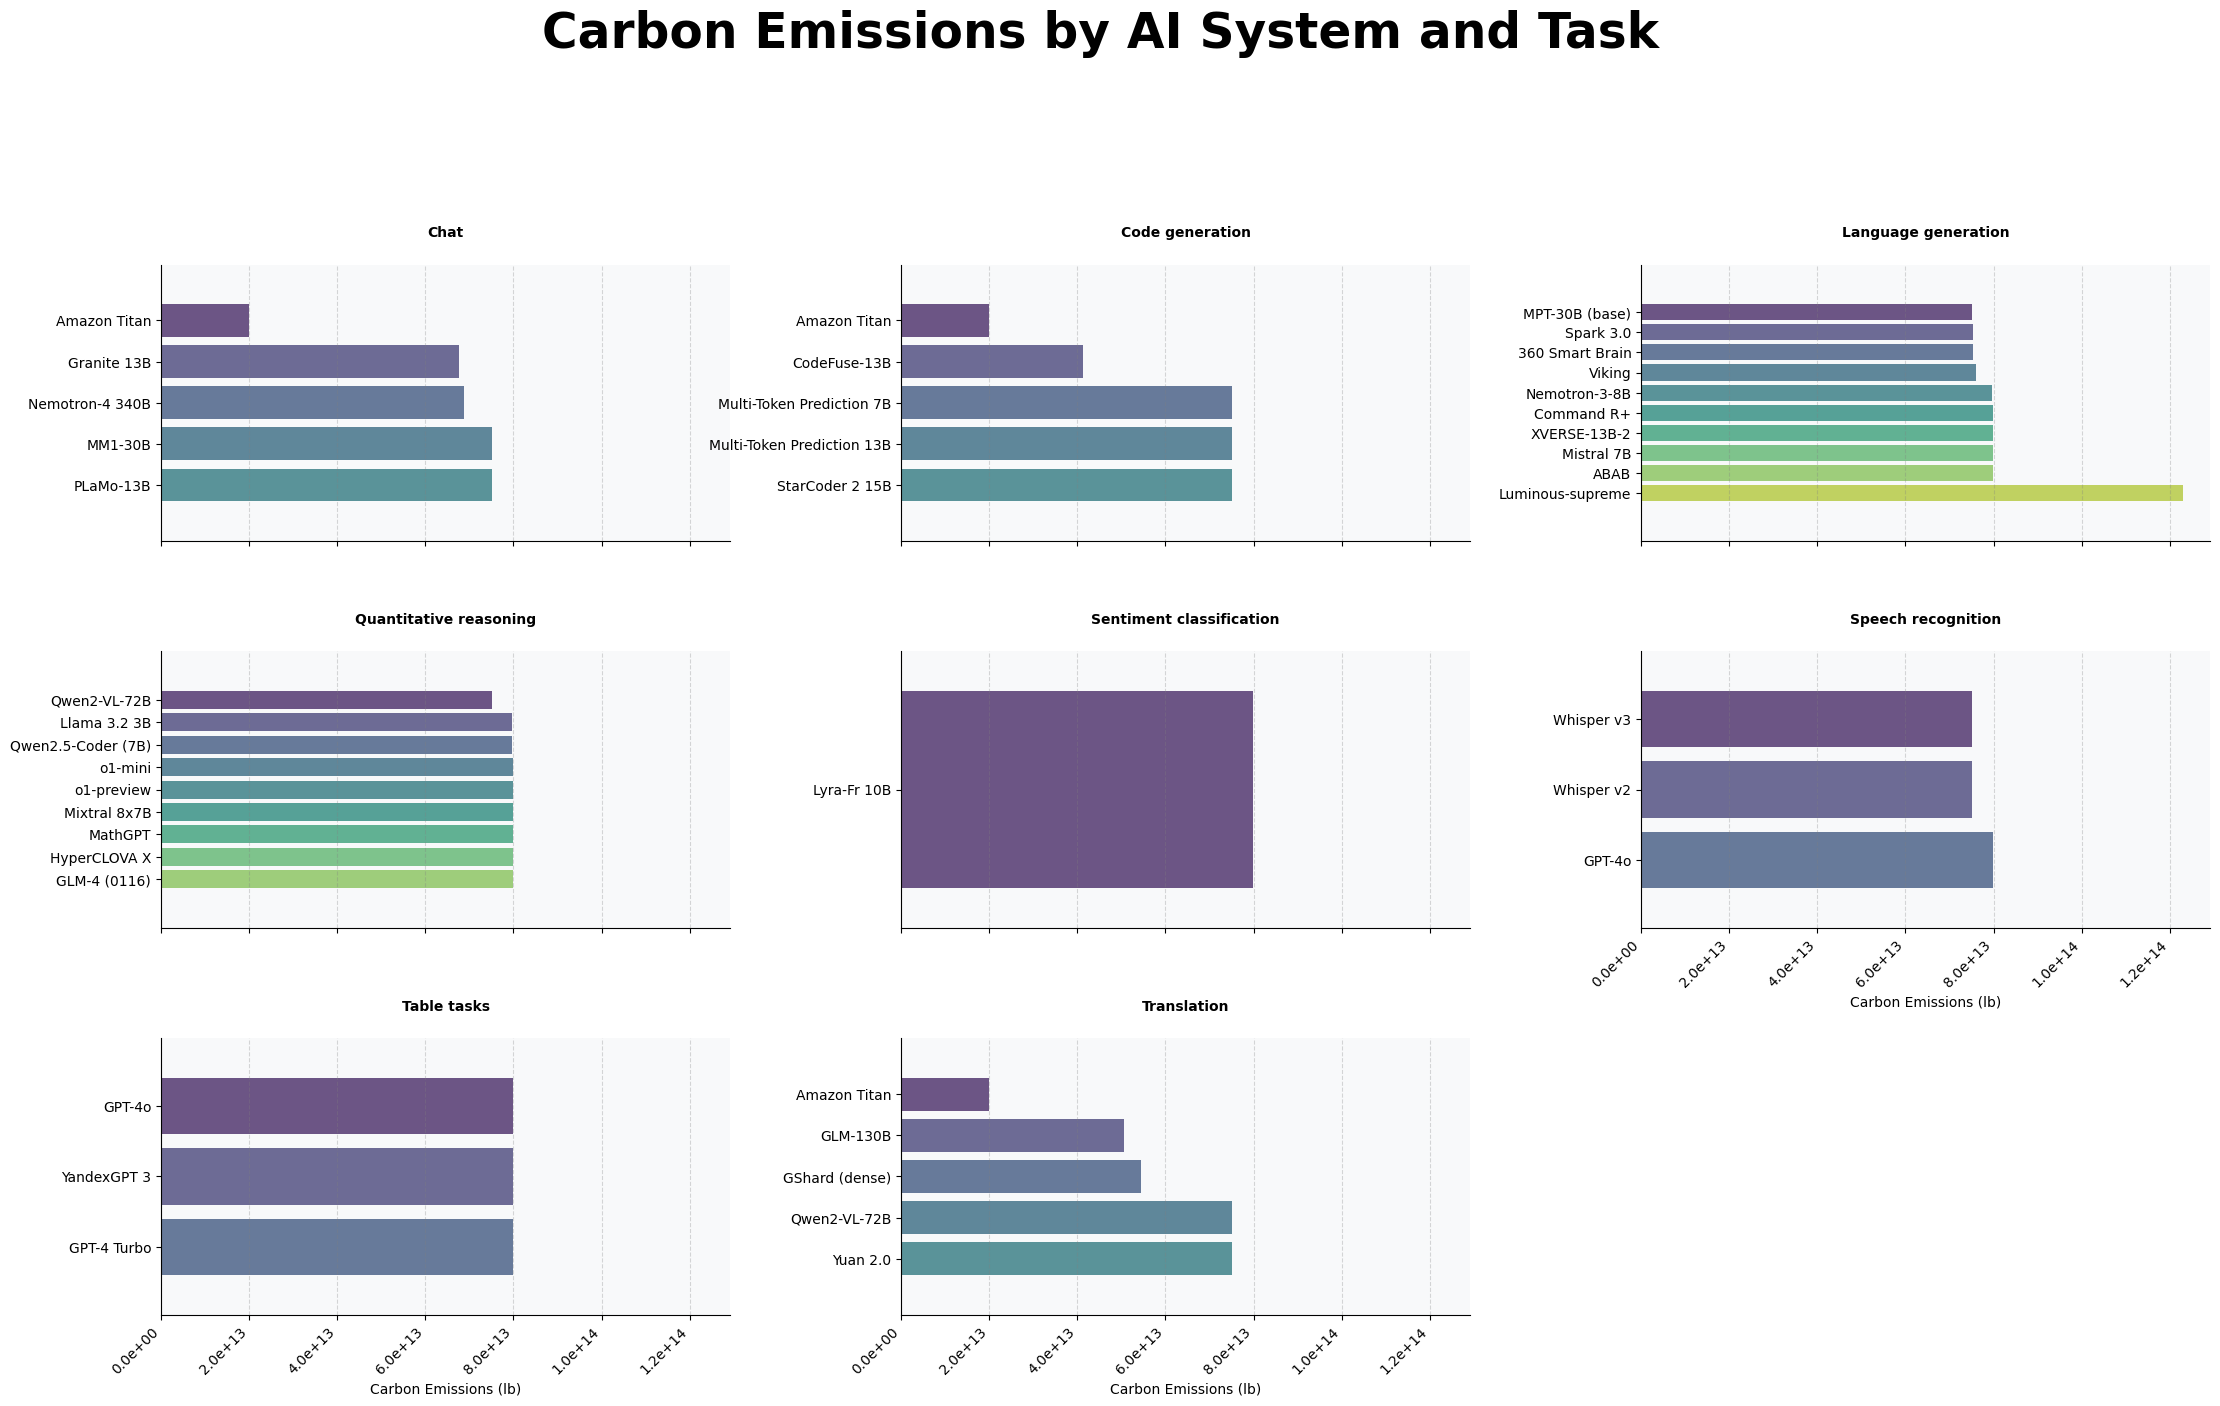

In [ ]:
plt.style.use('default')
colors = sns.color_palette("viridis", n_colors=10)
sns.set_palette(colors)

df_combined_finance = df_combined[df_combined['Task'].isin([
    "Quantitative reasoning",
    "Sentiment classification", 
    "Code generation",
    "Speech recognition",
    "Translation",
    "Fraud detection",
    "Chat",
    "Language generation",
    "Table tasks"
])]

df_filtered = (
    df_combined_finance[df_combined_finance['Task'].isin(["Chat", "Code generation", "Translation"])]
    .groupby('Task', group_keys=False)
    .apply(lambda x: x.nsmallest(5, 'Carbon Emissions from training (lb)'))
)

df_remaining = df_combined_finance[~df_combined_finance['Task'].isin(["Chat", "Code generation", "Translation"])]

df_combined_filtered = pd.concat([df_filtered, df_remaining], ignore_index=True)

df_combined_filtered = df_combined_filtered.sort_values(
    ['Task', 'Carbon Emissions from training (lb)'],
    ascending=[True, True]
)

plt.figure(figsize=(16, 10))
g = sns.FacetGrid(
    df_combined_filtered,
    col="Task",
    sharey=False,
    sharex=True,
    height=5,
    col_wrap=3,
    aspect=1.5
)

def custom_barplot(*args, **kwargs):
    ax = sns.barplot(*args, **kwargs, 
                    order=kwargs['data'].sort_values('Carbon Emissions from training (lb)')['System'],
                    palette=colors)
    for patch in ax.patches:
        patch.set_alpha(0.8)

g.map_dataframe(
    custom_barplot,
    x="Carbon Emissions from training (lb)",
    y="System",
    hue="System",
    dodge=False
)

for ax in g.axes.flat:
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.1e}"))
    ax.grid(axis='x', linestyle='--', alpha=0.3, color='gray')
    plt.setp(ax.patches, linewidth=1)
    ax.margins(y=0.2)
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')
    ax.set_facecolor('#f8f9fa')

g.set_titles("{col_name}", pad=20, fontsize=30, fontweight='bold')
g.set_axis_labels("Carbon Emissions (lb)", "")
g.fig.suptitle(
    "Carbon Emissions by AI System and Task",
    y=1.02,
    fontsize=35,
    fontweight='bold'
)

g.fig.subplots_adjust(
    top=0.85,
    bottom=0.15,
    wspace=0.3,
    hspace=0.4
)

g.fig.patch.set_facecolor('#ffffff')

plt.show()